# Edge coupler

Note: The cost of running the entire notebook is higher than 1 FlexUnit.

Fiber-to-chip couplers are essential components in photonic integrated circuits (PICs) that need to couple in/out light using optical fibers. However, the huge mismatch between the mode sizes of a single mode fiber ($\approx 10\mu m$ in diameter) and a silicon wire waveguide (220 x 500 nm) can cause significant coupling loss if they are coupled directly. For this reason, the design of the fiber-to-chip coupling devices is critical for the whole system's performance and needs to be carefully accomplished. There are two main categories of fiber-to-chip optical coupling devices: [grating couplers](https://docs.simulation.cloud/projects/tidy3d/en/latest/notebooks/GratingCoupler.html), where the optical fiber is positioned perpendicularly to the chip plane; and edge couplers, which allow in-plane light coupling by the direct alignment between the fiber and the integrated waveguide facets. 

In this notebook, we will show an example of using Tidy3D to evaluate the performance of edge couplers built using inverted taper mode transformers of linear, quadratic, and exponential profiles. We will also see how to set up a [Gaussian beam](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.GaussianBeam.html) to simulate the field launched by a lensed fiber and the use of [Batch](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.web.container.Batch.html) simulations to perform parameter sweeps.

We start by importing the necessary modules:

In [160]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# Tidy3D imports
import tidy3d as td
import tidy3d.web as web


## Simulation Setup

The inverted taper structure is made using an SOI platform consisting of a silicon (Si) substrate, a 3 $\mu m$ thick silicon dioxide (SiO2) layer, and a 220 nm thick silicon layer covered by 3 $\mu m$ thick silicon dioxide. As shown in the image below, the inverted taper is defined at the 220 nm thick Si layer, and its main geometric parameters are also defined in the figure. An optical fiber mode with a Gaussian profile (2.5 $\mu m$ spot-size) is focused at the taper tip and coupled into the output waveguide.   

<img src="img/EdgeCoupler.png" alt="Inverted Taper"  width="400"/>

Definition of the simulation wavelength and materials.

In [161]:
wl_c = 1.55  # Central wavelength.
wl_bw = 0.100  # Wavelength bandwidth.
wl_n = 101  # Number of wavelength points to compute the output data.

mat_si = td.Medium(permittivity=3.48**2)  # Taper and substrate material.
mat_sio2 = td.Medium(permittivity=1.44**2)  # Box and cladding material.
mat_air = td.Medium(permittivity=1.00)  # External medium material.


Definition of the taper size, lensed fiber parameters, and SOI structure.

In [162]:
taper_l = 25  # Taper length.
taper_w_in = 0.19  # Taper tip width.
taper_w_out = 0.50  # Taper output width.
taper_t = 0.22  # Taper thickness.

# Spot size of the gaussian mode launched by the lensed fiber at the taper tip.
spot_size = 2.5

box_thick = 3.0  # Silicon dioxide box layer.
clad_thick = 3.0  # Silicon dioxide layer covering the taper.


Calculated parameters and constants used in the simulation set up.

In [163]:
# Extra space around the taper at x,y directions.
pad_x = 1 * wl_c
pad_y = 1.5 * wl_c

# Wavelength and frequency values.
wl_range = np.linspace(wl_c - wl_bw / 2, wl_c + wl_bw / 2, wl_n)
freq_c = td.C_0 / wl_c
freq_range = td.C_0 / wl_range
freq_width = 0.5 * (np.max(freq_range) - np.min(freq_range))
run_time = 30 / freq_width

# Large number to be used in replacement of td.inf when necessary.
_inf = 1e3


Function to create the inverted taper geometry based on the work of [G. Ren et al. (2013)](https://www.sciencedirect.com/science/article/abs/pii/S0030401811006389).

In [164]:
# List of inverted tapers names.
tap_names = ["linear", "quadratic", "exponential"]


def get_taper(
    taper_shape="linear",
    init_coord=[pad_x, taper_w_in / 2],
    end_coord=[pad_x + taper_l, taper_w_out / 2],
):
    """Return a polygon composed of the taper vertices given the desired shape."""

    x0 = init_coord[0]
    x1 = end_coord[0]
    y0 = init_coord[1]
    y1 = end_coord[1]
    x = np.linspace(x0, x1, 41)

    tap_name = "linear_tap"
    if taper_shape == "quadratic":
        alpha = ((x - x0) / (x1 - x0)) ** 2
        tap_name = "quadratic_tap"
    elif taper_shape == "exponential":
        alpha = np.expm1((x - x0) / (x1 - x0)) / np.expm1(1)
        tap_name = "exponential_tap"
    elif taper_shape == "linear":
        alpha = (x - x0) / (x1 - x0)
    else:
        print(
            "taper_shape is neither 'linear', 'quadratic', or 'exponential'!\n"
            + "Linear taper shape returned!"
        )
        alpha = (x - x0) / (x1 - x0)

    y = y0 + alpha * (y1 - y0)
    upper_bound = [[xv, yv] for xv, yv in zip(x, y)] + [[_inf, y1]]
    lower_bound = [[_inf, -y1]] + [[xv, -yv] for xv, yv in zip(x[::-1], y[::-1])]
    taper_polygon = upper_bound + lower_bound

    # Inverted taper structure using a PolySlab.
    taper = td.Structure(
        geometry=td.PolySlab(
            vertices=taper_polygon, axis=2, slab_bounds=(-taper_t / 2, taper_t / 2)
        ),
        medium=mat_si,
        name=tap_name,
    )
    return taper


Function to create the simulation object. Since the box and cladding oxide layers are considerably thick, the silicon substrate and the upper air layer will be removed from the simulation, so being possible to take advantage of the symmetry along the z-axis. In addition, we will insert the Gaussian source directly into the taper tip to reduce the simulation cost further.

In [165]:
def get_simulations(
    tap_length=taper_l,
    tap_w_in=taper_w_in,
    tap_w_out=taper_w_out,
    tap_t=taper_t,
    tap_names=tap_names,
):
    """Return a dict of simulation objects for the content of 'tap_names'."""

    size_x = tap_length + 2 * pad_x
    size_y = tap_w_out + 2 * pad_y
    size_z = box_thick + clad_thick + tap_t

    # Gaussian source focused at the taper tip.
    # The Gaussian source must be placed at a plane within a uniform medium.
    gauss_source = td.GaussianBeam(
        center=(0.99 * pad_x, 0, 0),
        size=(0, size_y, size_z),
        source_time=td.GaussianPulse(freq0=freq_c, fwidth=freq_width),
        pol_angle=0,
        direction="+",
        num_freqs=7,
        waist_radius=spot_size / 2,
    )

    # Field monitor to visualize the fields throughout the length of the taper.
    field_monitor_xy = td.FieldMonitor(
        center=(size_x / 2, 0, 0),
        size=(size_x, size_y, 0),
        freqs=[freq_c],
        name="field_xy",
    )

    # Field monitor to visualize the Gaussian input fields.
    field_input = td.FieldMonitor(
        center=(pad_x, 0, 0),
        size=(0, size_y, size_z),
        freqs=[freq_c],
        name="field_input",
    )

    # Field monitor to visualize the fields at the output waveguide.
    field_output = td.FieldMonitor(
        center=(size_x - pad_x / 2, 0, 0),
        size=(0, size_y, size_z),
        freqs=[freq_c],
        name="field_output",
    )

    # Mode monitor to get the power coupled into the fundamental TE mode.
    mode_spec = td.ModeSpec(num_modes=1)
    mode_monitor = td.ModeMonitor(
        center=(size_x - pad_x / 2, 0, 0),
        size=(0, size_y, size_z),
        freqs=freq_range,
        mode_spec=mode_spec,
        name="mode_0",
    )

    # Silicon dioxide box + cladding layers
    sio2_medium = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(pad_x, -_inf, -_inf), rmax=(_inf, _inf, _inf)
        ),
        medium=mat_sio2,
    )

    # Simulation definition
    sim_tap = []
    for t_name in tap_names:
        taper_poly = get_taper(
            t_name,
            init_coord=[pad_x, tap_w_in / 2],
            end_coord=[size_x - pad_x, tap_w_out / 2],
        )

        sim_tap.append(
            td.Simulation(
                center=(size_x / 2, 0, 0),
                size=(size_x, size_y, size_z),
                medium=mat_air,
                grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=wl_c),
                structures=[sio2_medium, taper_poly],
                sources=[gauss_source],
                normalize_index=0,
                monitors=[field_monitor_xy, field_input, field_output, mode_monitor],
                boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML(num_layers=20)),
                symmetry=(0, -1, 1),
                run_time=run_time,
            )
        )
    sims = {sim_name: sim for sim_name, sim in zip(tap_names, sim_tap)}
    return sims


## Comparison between inverted tapers with different shapes.

We start our analysis by comparing the response of inverted tapers with 3 different geometries: linear, quadratic, and exponential. Then, before running the simulations, we will visualize the shapes of the inverted tapers and examine the simulation set up to see if everything is correct.

In [166]:
# Get the list of simulation objects.
sim_tap = get_simulations(tap_length=taper_l)


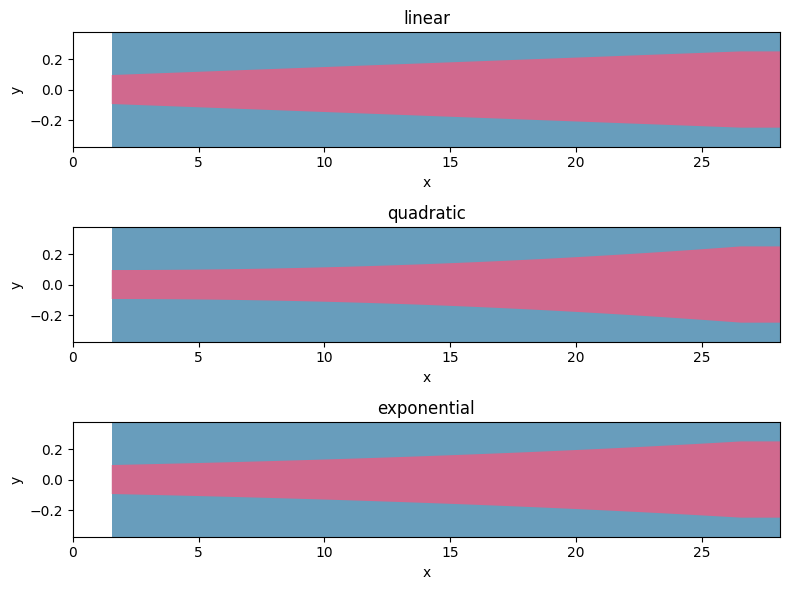

In [167]:
# Structure visualization.
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8, 6))
for sim_s, tap_n, ax in zip(sim_tap.values(), sim_tap.keys(), axs):
    sim_s.plot_structures(z=0, ax=ax)
    ax.set_xlim(0, 2 * pad_x + taper_l)
    ax.set_ylim(-1.5 * taper_w_out / 2, 1.5 * taper_w_out / 2)
    ax.set_aspect("auto")  # Used to better visualize the shapes.
    ax.set_title(tap_n)
plt.show()


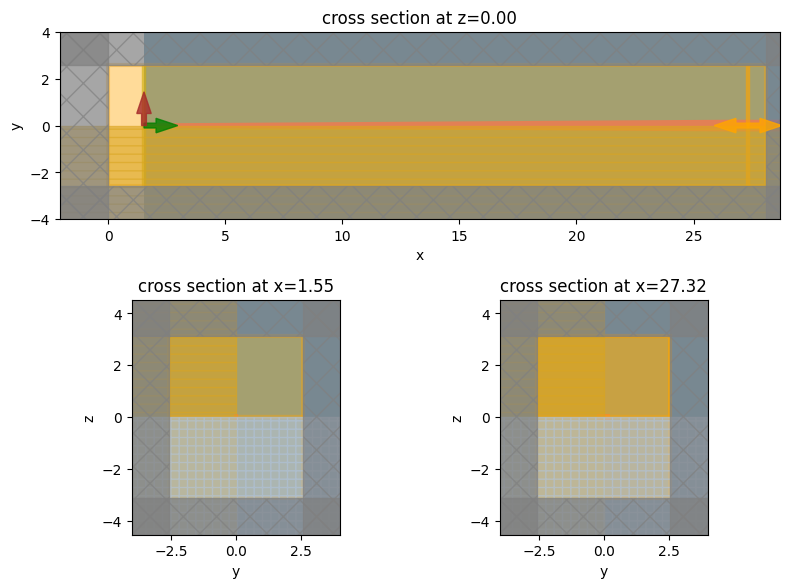

In [168]:
# Simulation set up visualization.
fig = plt.figure(tight_layout=True, figsize=(8, 6))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
sim_tap["linear"].plot(z=0, ax=ax1)
sim_tap["linear"].plot(x=pad_x, ax=ax2)
sim_tap["linear"].plot(x=pad_x + taper_l + pad_x / 2, ax=ax3)
plt.show()


Now, we will run the simulations using a batch object.

In [169]:
# Initialize a simulation batch.
batch = web.Batch(simulations=sim_tap)

# Get the estimated simulation cost.
tot_cost = 0
for bat in batch.get_info().values():
    sim_name = bat.taskName
    cost = web.estimate_cost(bat.taskId)
    tot_cost += cost
    print("Estimated FlexUnit cost for " + sim_name + " =", cost)
print("Total estimated FlexUnit cost for batch =", tot_cost)


[11:43:27] INFO     Created task 'linear' with task_id 'b98a31a4-d45f-4e47-86db-3df9b224cfed'.        ]8;id=503091;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=965768;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\

Output()

[11:43:30] INFO     Created task 'quadratic' with task_id '4d0b3e25-2237-4c81-99e5-62cab6c9101b'.     ]8;id=298346;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=635046;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\

Output()

[11:43:32] INFO     Created task 'exponential' with task_id 'f374f37d-0041-4f51-b58e-5e4ad3c1c06c'.   ]8;id=156597;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=305472;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\

Output()

Estimated FlexUnit cost for linear = 0.11789150620527468
Estimated FlexUnit cost for quadratic = 0.11789150620527468
Estimated FlexUnit cost for exponential = 0.11789150620527468
Total estimated FlexUnit cost for batch = 0.35367451861582405


Run the batch and store all of the data in the `data_taper` dir.

In [170]:
batch_taper = batch.run(path_dir="data_taper")


[11:43:41] Started working on Batch.                                                               ]8;id=401530;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=548930;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#361\361]8;;\

Output()

[11:44:35] Batch complete.                                                                         ]8;id=584025;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=260999;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#382\382]8;;\

### Inverted taper results
Now we will see the field intensity and the modal coupling efficiency for the 3 inverted tapers.

In [190]:
sim_tap_results = {tl: sn for tl, sn in batch_taper.items()}


[12:05:17] INFO     loading SimulationData from data_taper\b98a31a4-d45f-4e47-86db-3df9b224cfed.hdf5  ]8;id=812984;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=329343;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

           INFO     loading SimulationData from data_taper\4d0b3e25-2237-4c81-99e5-62cab6c9101b.hdf5  ]8;id=103806;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=918901;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

           INFO     loading SimulationData from data_taper\f374f37d-0041-4f51-b58e-5e4ad3c1c06c.hdf5  ]8;id=218896;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=578111;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

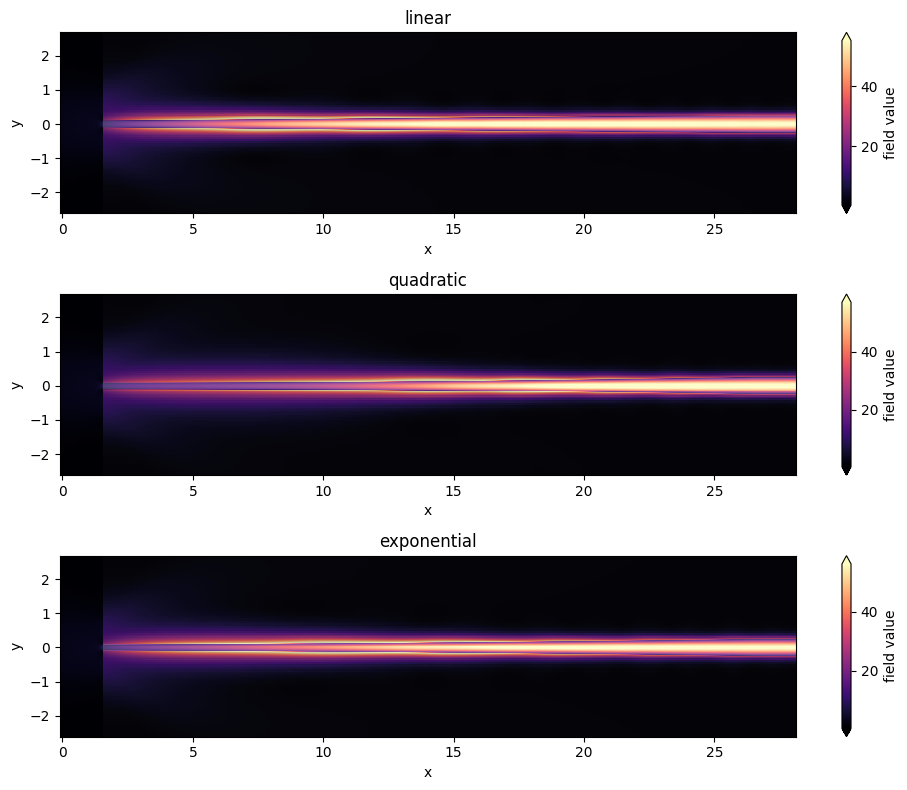

In [191]:
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(10, 8))
for tap_n, sim_data, ax in zip(sim_tap_results.keys(), sim_tap_results.values(), axs):
    sim_data.plot_field("field_xy", "Ey", f=freq_c, val="abs", ax=ax)
    ax.set_title(tap_n)
    ax.set_aspect("auto")  # Used to better visualize the shapes.
plt.show()


Bellow, we have the $|E_{y}|$ field recorded by the monitors positioned at the taper tip and taper output of the quadratic structure. We can clearly visualize the Gaussian profile corresponding to the fields launched by a lensed fiber at the taper tip. In contrast, the output field corresponds to the transverse electric polarization of the fundamental output waveguide mode.

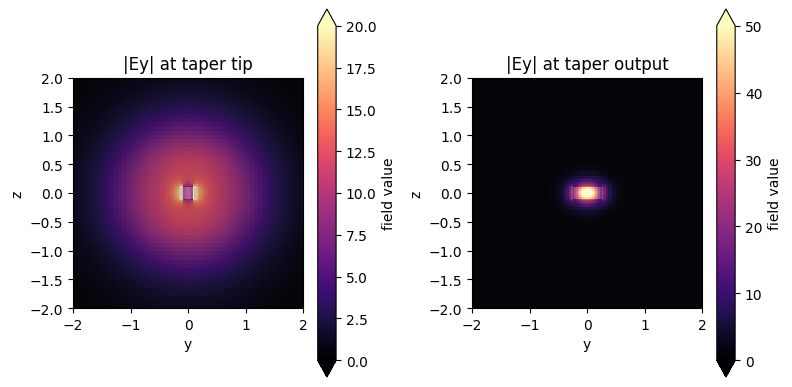

In [192]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim_tap_results["quadratic"].plot_field(
    "field_input", "Ey", f=freq_c, val="abs", ax=ax1
)
ax1.set_title("|Ey| at taper tip")
ax1.collections[-1].set_clim(0, 20)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)

sim_tap_results["quadratic"].plot_field(
    "field_output", "Ey", f=freq_c, val="abs", ax=ax2
)
ax2.set_title("|Ey| at taper output")
ax2.collections[-1].set_clim(0, 50)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
plt.show()


The modal coupling efficiencies shown below reveal that the quadratic taper profile has the lowest insertion losses.

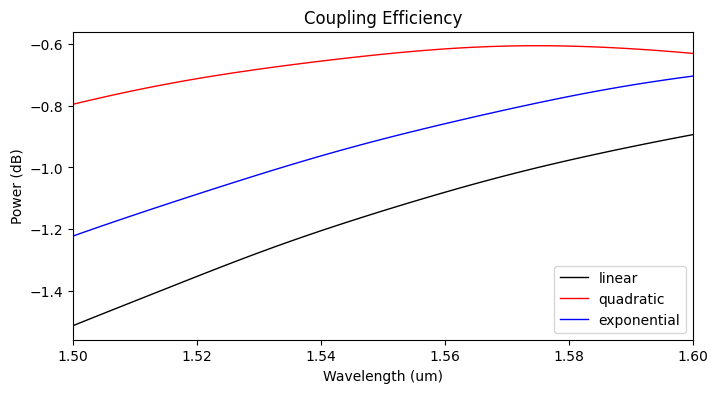

In [193]:
power_tap_25 = []
for sim_data in sim_tap_results.values():
    mode_amps = sim_data["mode_0"]
    coeffs_f = mode_amps.amps.sel(direction="+")
    power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
    power_0_db = 10 * np.log10(power_0)
    power_tap_25.append(power_0_db)

plot_colors = ("black", "red", "blue")
fig, ax1 = plt.subplots(1, figsize=(8, 4))
for data, color, label in zip(power_tap_25, plot_colors, sim_tap_results.keys()):
    ax1.plot(
        wl_range,
        data,
        color=color,
        linestyle="solid",
        linewidth=1.0,
        label=label,
    )
ax1.set_xlim([wl_range[0], wl_range[-1]])
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Power (dB)")
ax1.set_title("Coupling Efficiency")
plt.legend()
plt.show()


## Inverted Taper Length Sweep
Before, we simulated the inverted tapers with a short length of only 25 $\mu m$ to improve simulation time. Nevertheless, the designs can be improved by making the inverted taper larger in length so that its adiabaticity is increased. In the following sections, we increase the taper length to 50 $\mu m$ and 100 $\mu m$ (other values can be added to the sweep at a higher simulation cost).

In [194]:
# Taper lengths on the sweep.
taper_sweep = [50, 100]
sim_sweep = [get_simulations(tap_length=t_l) for t_l in taper_sweep]

# Make a dictionary of {task name : simulation}
sims = {
    f"sim_{tap_l}_{sim_name}": sim
    for sim_l, tap_l in zip(sim_sweep, taper_sweep)
    for sim, sim_name in zip(sim_l.values(), sim_l.keys())
}
# Initialize a batch and run them all
batch = web.Batch(simulations=sims)

# Get the estimated simulation cost.
tot_cost = 0
for bat in batch.get_info().values():
    sim_name = bat.taskName
    cost = web.estimate_cost(bat.taskId)
    tot_cost += cost
    print("Estimated FlexUnit cost for " + sim_name + " =", cost)
print("Total estimated FlexUnit cost for batch =", tot_cost)


[12:07:37] INFO     Created task 'sim_50_linear' with task_id '9495f368-c9e6-4e44-afcc-0ada7cb9093d'. ]8;id=355790;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=444614;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\

Output()

[12:07:40] INFO     Created task 'sim_50_quadratic' with task_id                                      ]8;id=119128;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=518239;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\
                    '3a67cbfe-7f7a-4177-b240-704a55e09d74'.                                                        

Output()

[12:07:42] INFO     Created task 'sim_50_exponential' with task_id                                    ]8;id=987241;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=506743;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\
                    '56bcf16c-cb10-4c2c-ba38-5e621a64af1e'.                                                        

Output()

[12:07:44] INFO     Created task 'sim_100_linear' with task_id                                        ]8;id=546334;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=622680;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\
                    'b3fa1347-6e31-4ab7-a950-d3638dd34ee4'.                                                        

Output()

[12:07:46] INFO     Created task 'sim_100_quadratic' with task_id                                     ]8;id=477327;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=327863;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\
                    '4aae2576-337b-4ba3-a701-373de418dbf0'.                                                        

Output()

[12:07:49] INFO     Created task 'sim_100_exponential' with task_id                                   ]8;id=914440;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=829903;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\
                    'c3f2bad6-b3f9-4b26-a249-a647143e006f'.                                                        

Output()

Estimated FlexUnit cost for sim_50_linear = 0.22035083343825837
Estimated FlexUnit cost for sim_50_quadratic = 0.22035083343825837
Estimated FlexUnit cost for sim_50_exponential = 0.22035083343825837
Estimated FlexUnit cost for sim_100_linear = 0.4245239676033002
Estimated FlexUnit cost for sim_100_quadratic = 0.4245239676033002
Estimated FlexUnit cost for sim_100_exponential = 0.4245239676033002
Total estimated FlexUnit cost for batch = 1.9346244031246755


Run the batch and store all of the data in the `data_sweep` dir.

In [195]:
batch_sweep = batch.run(path_dir="data_sweep")


[12:08:17] Started working on Batch.                                                               ]8;id=378609;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=91817;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#361\361]8;;\

Output()

[12:12:29] Batch complete.                                                                         ]8;id=513432;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=716328;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#382\382]8;;\

Print the simulation log corresponding to the longest inverted taper to inspection.

In [196]:
print(batch_sweep["sim_100_quadratic"].log)


[12:12:41] INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=25867;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=613236;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#593\593]8;;\
                    "data_sweep\4aae2576-337b-4ba3-a701-373de418dbf0.hdf5"                                         

Output()

[12:12:55] INFO     loading SimulationData from data_sweep\4aae2576-337b-4ba3-a701-373de418dbf0.hdf5  ]8;id=219566;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=43603;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

Simulation domain Nx, Ny, Nz: [3477, 126, 136]
Applied symmetries: (0, -1, 1)
Number of computational grid points: 1.5829e+07.
Using subpixel averaging: True
Number of time steps: 8.9104e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 5.3908e-17


Compute source modes time (s):     0.4615
Compute monitor modes time (s):    32.8671
Rest of setup time (s):            11.1124

Running solver for 89104 time steps...
- Time step   2364 / time 1.27e-13s (  2 % done), field decay: 1.00e+00
- Time step   3564 / time 1.92e-13s (  4 % done), field decay: 1.00e+00
- Time step   7128 / time 3.84e-13s (  8 % done), field decay: 7.76e-01
- Time step  10692 / time 5.76e-13s ( 12 % done), field decay: 5.40e-01
- Time step  14256 / time 7.69e-13s ( 16 % done), field decay: 4.18e-01
- Time step  17820 / time 9.61e-13s ( 20 % done), field decay: 3.55e-01
- Time step  21384 / time 1.15e-12s ( 24 % done), field decay: 3.02e-01
- Time step  24949 / time 1.34e-12s ( 28 % done), field decay: 1.31e-05
- 

### Parameter sweep results

Now, we will get the batch results and plot the modal coupling efficiency at the central wavelength as a function of the inverted taper length.

In [197]:
coup_eff_tl = np.zeros((len(tap_names), len(taper_sweep) + 1))
for i in range(len(tap_names)):
    coup_eff_tl[i, 0] = power_tap_25[i].sel(f=freq_c)

sims = {
    f"sim_{tap_l}_{sim_name}": sim
    for sim_l, tap_l in zip(sim_sweep, taper_sweep)
    for sim, sim_name in zip(sim_l.values(), sim_l.keys())
}

for j, tl in enumerate(taper_sweep):
    for i, sn in enumerate(tap_names):
        data_sim = batch_sweep[f"sim_{tl}_{sn}"]
        mode_amps = data_sim["mode_0"]
        coeffs_f = mode_amps.amps.sel(direction="+", f=freq_c)
        power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
        power_0_db = 10 * np.log10(power_0)
        coup_eff_tl[i, j + 1] = power_0_db


[12:13:01] INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=608667;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=695896;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#593\593]8;;\
                    "data_sweep\9495f368-c9e6-4e44-afcc-0ada7cb9093d.hdf5"                                         

Output()

[12:13:05] INFO     loading SimulationData from data_sweep\9495f368-c9e6-4e44-afcc-0ada7cb9093d.hdf5  ]8;id=546138;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=483497;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=834622;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=963732;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#593\593]8;;\
                    "data_sweep\3a67cbfe-7f7a-4177-b240-704a55e09d74.hdf5"                                         

Output()

[12:13:09] INFO     loading SimulationData from data_sweep\3a67cbfe-7f7a-4177-b240-704a55e09d74.hdf5  ]8;id=182538;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=765035;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

[12:13:10] INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=57034;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=497425;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#593\593]8;;\
                    "data_sweep\56bcf16c-cb10-4c2c-ba38-5e621a64af1e.hdf5"                                         

Output()

[12:13:13] INFO     loading SimulationData from data_sweep\56bcf16c-cb10-4c2c-ba38-5e621a64af1e.hdf5  ]8;id=665691;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=932163;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

[12:13:14] INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=308040;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=481368;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#593\593]8;;\
                    "data_sweep\b3fa1347-6e31-4ab7-a950-d3638dd34ee4.hdf5"                                         

Output()

[12:13:19] INFO     loading SimulationData from data_sweep\b3fa1347-6e31-4ab7-a950-d3638dd34ee4.hdf5  ]8;id=660243;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=755387;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

           INFO     loading SimulationData from data_sweep\4aae2576-337b-4ba3-a701-373de418dbf0.hdf5  ]8;id=719014;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=32376;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=601873;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=482814;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#593\593]8;;\
                    "data_sweep\c3f2bad6-b3f9-4b26-a249-a647143e006f.hdf5"                                         

Output()

[12:13:24] INFO     loading SimulationData from data_sweep\c3f2bad6-b3f9-4b26-a249-a647143e006f.hdf5  ]8;id=733783;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=420381;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

As shown below, the longer the taper, the higher the modal coupling efficiency, as is expected due to the increased adiabaticity. However, the quadratic shape profile seems more advantageous for this case as it achieved a steady state coupling loss of $\lt$ 0.6 dB for a 50 $\mu m$ taper length. In contrast, the exponential shape needs double this value, and an even longer taper length would be necessary for the linear profile to obtain similar coupling loss. Detailed discussions about the effects of taper profile over the coupling efficiency, bandwidth, footprint size, or taper/fiber misalignments can be found in the literature [[1](https://www.mdpi.com/2076-3417/10/4/1538),[2](https://opg.optica.org/prj/fulltext.cfm?uri=prj-7-2-201&id=404538),[3](https://www.sciencedirect.com/science/article/abs/pii/S0030401811006389)].   


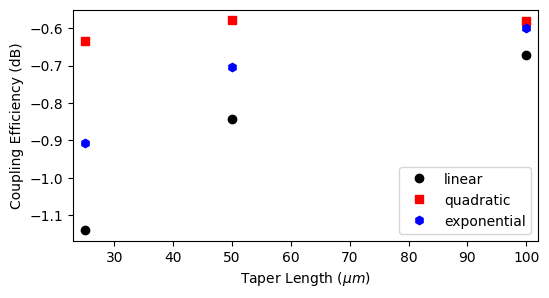

In [198]:
fig, ax = plt.subplots(1, figsize=(6, 3))
lin_style = ["ok", "sr", "hb"]
taper_lengths = [taper_l] + taper_sweep[:]
for ce, ls, lab in zip(coup_eff_tl, lin_style, tap_names):
    ax.plot(taper_lengths, ce, ls, label=lab)
ax.set_xlim([taper_lengths[0] - 2, taper_lengths[-1] + 2])
ax.set_xlabel("Taper Length ($\mu m$)")
ax.set_ylabel("Coupling Efficiency (dB)")
plt.legend()
plt.show()


Next, we will visualize the field distribution and the wavelength-dependent coupling coefficients for these longer inverted taper structures.

[12:13:55] INFO     loading SimulationData from data_sweep\b3fa1347-6e31-4ab7-a950-d3638dd34ee4.hdf5  ]8;id=163856;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=114546;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

           INFO     loading SimulationData from data_sweep\3a67cbfe-7f7a-4177-b240-704a55e09d74.hdf5  ]8;id=142235;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=9445;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

[12:13:56] INFO     loading SimulationData from data_sweep\c3f2bad6-b3f9-4b26-a249-a647143e006f.hdf5  ]8;id=719918;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=860008;file://c:\Users\user\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#415\415]8;;\

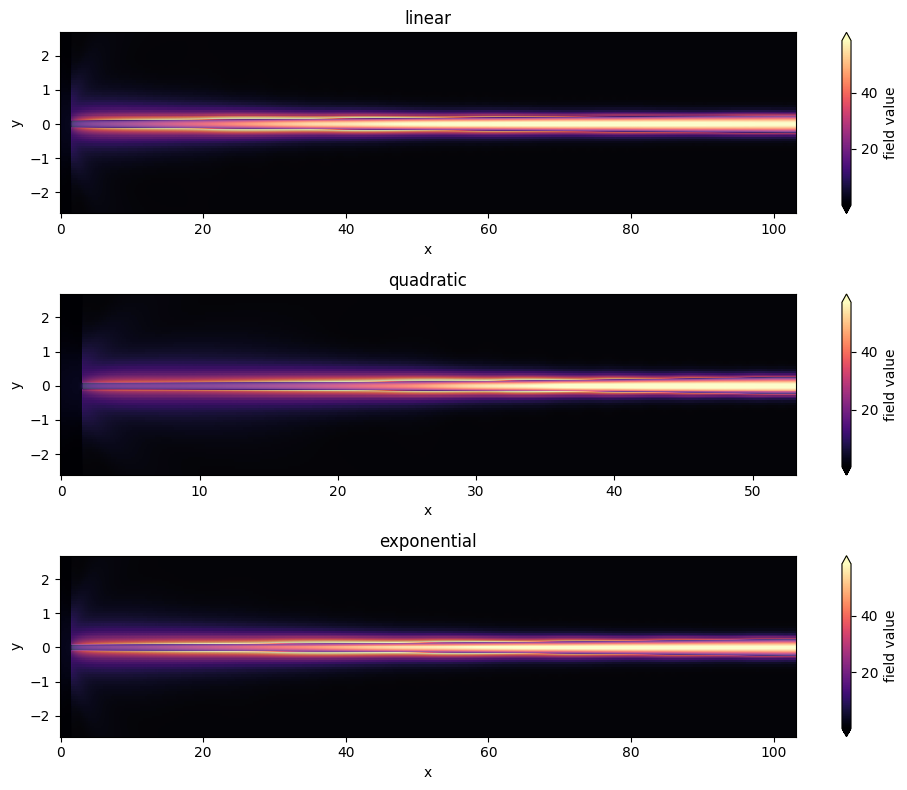

In [199]:
final_sim_data = [
    batch_sweep["sim_100_linear"],
    batch_sweep["sim_50_quadratic"],
    batch_sweep["sim_100_exponential"],
]

fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(10, 8))
for sim_data, tap_n, ax in zip(final_sim_data, tap_names, axs):
    sim_data.plot_field("field_xy", "Ey", f=freq_c, val="abs", ax=ax)
    ax.set_title(tap_n)
    ax.set_aspect("auto")  # Used to better visualize the shapes.
plt.show()


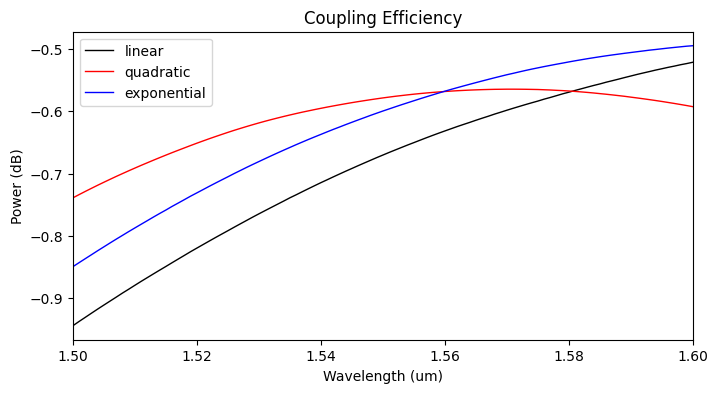

In [200]:
plot_colors = ("black", "red", "blue")
fig, ax1 = plt.subplots(1, figsize=(8, 4))
for sim_data, color, label in zip(final_sim_data, plot_colors, tap_names):
    mode_amps = sim_data["mode_0"]
    coeffs_f = mode_amps.amps.sel(direction="+")
    power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
    power_0_db = 10 * np.log10(power_0)

    ax1.plot(
        wl_range,
        power_0_db,
        color=color,
        linestyle="solid",
        linewidth=1.0,
        label=label,
    )
ax1.set_xlim([wl_range[0], wl_range[-1]])
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Power (dB)")
ax1.set_title("Coupling Efficiency")
plt.legend()
plt.show()
